### Import dataset

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans

In [3]:
df = pd.read_excel('./SRC/Real estate valuation data set.xlsx')

### Features analisis

In [4]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
df['X1 transaction date'].describe()

count     414.000000
mean     2013.148953
std         0.281995
min      2012.666667
25%      2012.916667
50%      2013.166667
75%      2013.416667
max      2013.583333
Name: X1 transaction date, dtype: float64

Over time, a product tends to undergo changes in its price, either appreciation or depreciation. However, less than 1 year as shown in this dataset will not imply the final result.

In [6]:
df = df.drop(columns=['No', 'X1 transaction date'])

Data and No are features that don't make a difference in our analysis, they will soon be excluded.

### Simple training

In [7]:
models = {
    'MLPRegressor': MLPRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(),
}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Y house price of unit area']), df['Y house price of unit area'],test_size=0.25,shuffle=True, random_state=10)

dataframe = {
    'Score':[],
    'Metric':[],
    'Model':[]
}

for model in models:
    regressor = models[model]
    regressor.fit(X_train, y_train)
    y_predict = regressor.predict(X_test)
    dataframe['Score'] += [mean_absolute_error(y_test, y_predict), np.sqrt(mean_squared_error(y_test,y_predict))]
    dataframe['Metric'] += ['MAE', 'RMSE']
    dataframe['Model'] += [model, model]

/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
dataframe = pd.DataFrame(dataframe)
dataframe

,Score,Metric,Model
0,5.982234,MAE,MLPRegressor
1,9.065979,RMSE,MLPRegressor
2,5.079506,MAE,RandomForestRegressor
3,7.396757,RMSE,RandomForestRegressor
4,7.187240,MAE,SVR
5,9.728818,RMSE,SVR


<AxesSubplot:xlabel='Model', ylabel='Score'>

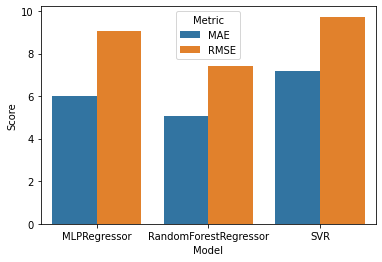

In [10]:
sb.barplot(x=dataframe['Model'], y=dataframe['Score'], hue=dataframe['Metric'])

### Advanced training

#### Gruped

In [11]:
groups = KMeans(n_clusters=5).fit(df.drop(columns=['X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores','Y house price of unit area']))
df['Groups'] = groups.labels_

#### Training

In [12]:
models = {
    'MLPRegressor 1LAYER': MLPRegressor(),
    'MLPRegressor 2LAYER': MLPRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR Linear': SVR()
}
one_layer =[(np.random.randint(100,200),),(np.random.randint(200,300),),(np.random.randint(300,400),)]
two_layer = [(np.random.randint(100,200), np.random.randint(100,200)),(np.random.randint(200,400), np.random.randint(100,200)),(np.random.randint(200,400), np.random.randint(200,400))]

params = {
    'MLPRegressor 1LAYER': {'max_iter':[4000], 'hidden_layer_sizes':one_layer},
    'MLPRegressor 2LAYER': {'max_iter':[4000], 'hidden_layer_sizes':two_layer},    
    'RandomForestRegressor': {'n_estimators':[100, np.random.randint(50,100),np.random.randint(100,150), np.random.randint(150,300),np.random.randint(300,400)]},
    'SVR Linear':{},
    'SVR Poly': {'kernel':['poly', 'rbf'], 'degree':[2,3,4]}
}

In [13]:
normalizer = Normalizer().fit(df.drop(columns=['Y house price of unit area']))
standardizer = StandardScaler().fit(df.drop(columns=['Y house price of unit area']))

In [14]:
def training_with_grid(models, params, df, y, processing, random_state, drop):
    
    df_results = {
        'Model':[],
        'Metric':[],
        'Params':[],
        'Processing':[],
        'Score':[],
        'Drop':[]
    }
    if drop == []:
        drop = 'No drop'
    else:
        X = df.drop(columns=drop)
        drop = ', '.join(drop)

    X = df.drop(columns=y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, df[y],test_size=0.25,shuffle=True, random_state=random_state)
    
    if processing == 'Normalizer':
        X_train = normalizer.transform(X_train)
        X_test = normalizer.transform(X_test)

    if processing == 'Standarlizer':
        X_train = standardizer.transform(X_train)
        X_test = standardizer.transform(X_test)

    for name in models:
        model = GridSearchCV(models[name], params[name])
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)    
        df_results['Model']+= [name,name]
        df_results['Drop']+= [drop,drop]
        df_results['Params']+= [model.best_params_,model.best_params_] 
        df_results['Processing']+= [processing,processing]
        df_results['Score']+= [mean_absolute_error(y_test, y_predict), np.sqrt(mean_squared_error(y_test, y_predict))]
        df_results['Metric']+= ['MAE', 'RMSE']
    return df_results

In [15]:
drops = [[], ['X5 latitude','X6 longitude'], ['Groups'], ['X5 latitude','X6 longitude','Groups']]
processings = ['No', 'Normalizer', 'Standarlizer']
dataframe = pd.DataFrame()
y = 'Y house price of unit area'
for i in drops:
    for j in processings:
        df_results = pd.DataFrame(training_with_grid(models,params, df, y, j, 10, i))
        dataframe = pd.concat([dataframe, df_results],ignore_index=True)

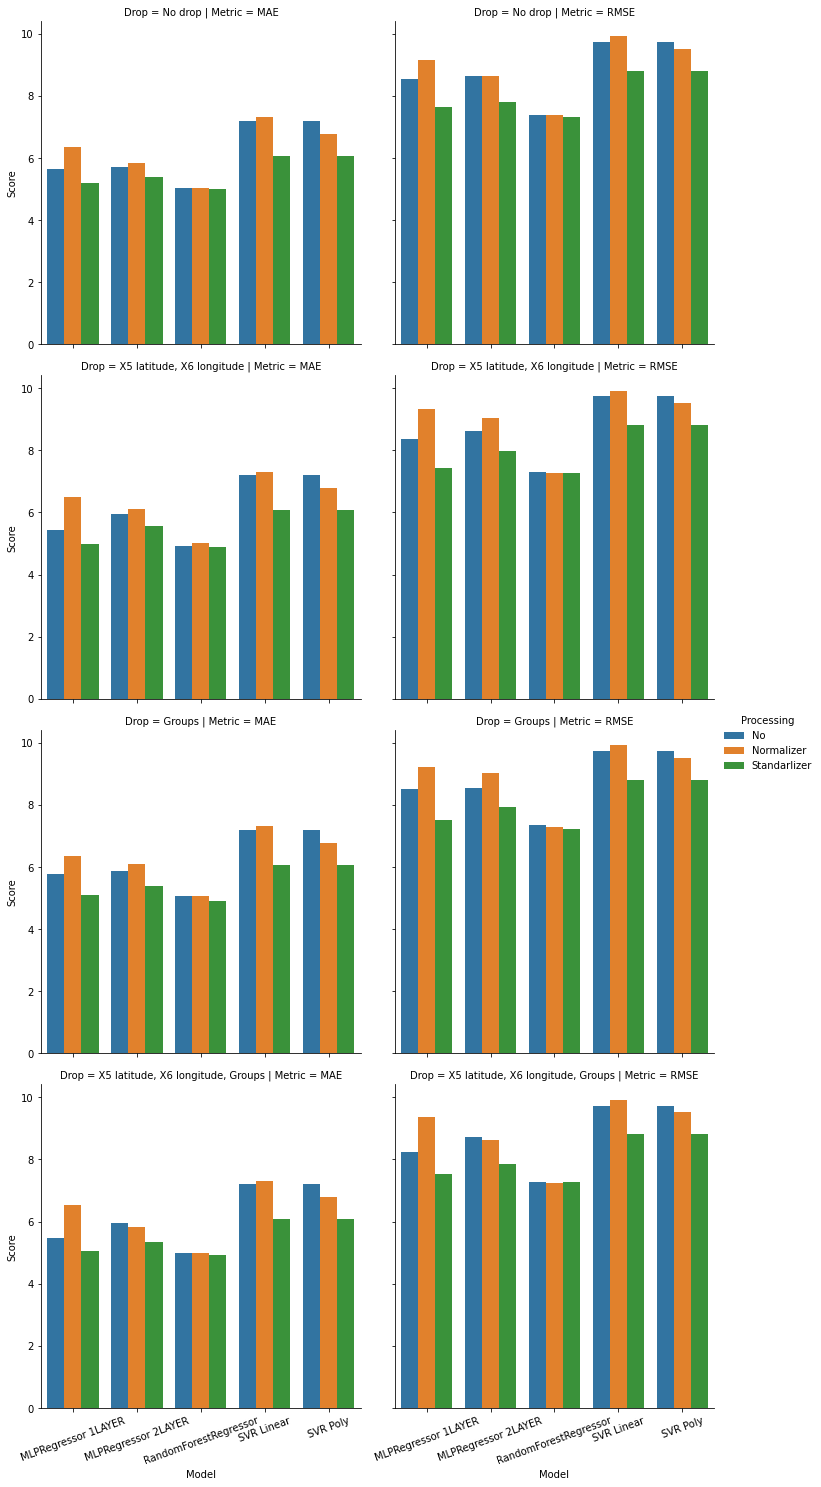

In [16]:
plot = sb.catplot(x='Model', y='Score',data=dataframe,col='Metric', row='Drop',hue='Processing', kind='bar')
for ax in plot.axes.flat:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

This code consists of training and selecting hyperparameters and resources. Various features, parameters, processing, regression models and metrics are tested.

The MLP and SVR regression models obtained better scores using standardization as pre-processing. On the other hand, the RandomForest model, which was already very good without changes, got better scores with Normalization and excluding the Latitude and Longitude features.

### Getting better model and params

In [25]:
dataframe = dataframe.sort_values(by='Score')
dataframe.groupby(by='Metric').head()

,Model,Metric,Params,Processing,Score,Drop
54,RandomForestRegressor,MAE,{'n_estimators': 119},Standarlizer,4.903957,"X5 latitude, X6 longitude"
84,RandomForestRegressor,MAE,{'n_estimators': 367},Standarlizer,4.909488,Groups
114,RandomForestRegressor,MAE,{'n_estimators': 246},Standarlizer,4.914414,"X5 latitude, X6 longitude, Groups"
34,RandomForestRegressor,MAE,{'n_estimators': 73},No,4.931844,"X5 latitude, X6 longitude"
50,MLPRegressor 1LAYER,MAE,"{'hidden_layer_sizes': (391,), 'max_iter': 4000}",Standarlizer,4.972053,"X5 latitude, X6 longitude"
105,RandomForestRegressor,RMSE,{'n_estimators': 119},Normalizer,7.229591,"X5 latitude, X6 longitude, Groups"
85,RandomForestRegressor,RMSE,{'n_estimators': 367},Standarlizer,7.233722,Groups
55,RandomForestRegressor,RMSE,{'n_estimators': 119},Standarlizer,7.256456,"X5 latitude, X6 longitude"
45,RandomForestRegressor,RMSE,{'n_estimators': 119},Normalizer,7.263488,"X5 latitude, X6 longitude"
115,RandomForestRegressor,RMSE,{'n_estimators': 246},Standarlizer,7.267773,"X5 latitude, X6 longitude, Groups"


In [26]:
df.head()

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,Groups
0,32.0,84.87882,10,24.98298,121.54024,37.9,3
1,19.5,306.59470,9,24.98034,121.53951,42.2,3
2,13.3,561.98450,5,24.98746,121.54391,47.3,3
3,13.3,561.98450,5,24.98746,121.54391,54.8,3
4,5.0,390.56840,5,24.97937,121.54245,43.1,3


#### Checking consistency

In [18]:
mean = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['X5 latitude', 'X6 longitude','Y house price of unit area']),df['Y house price of unit area'], shuffle=True, random_state=i)
    normalizer = Normalizer().fit(X_train)
    X_train = normalizer.transform(X_train)
    X_test = normalizer.transform(X_test)
    regressor = GridSearchCV(RandomForestRegressor(), {'n_estimators': [100]})
    regressor.fit(X_train, y_train)
    mean.append(mean_absolute_error(y_test,regressor.predict(X_test)))

In [19]:
print('Média de 50 iterações', np.mean(mean))
print('Desvio padrão: ',np.std(mean))

Média de 50 iterações 4.920815164082178
Desvio padrão:  0.4907921636578552


Model is consistent so it's time to save the file.

### Saving files

In [20]:
import os
import joblib
save_models_path = './results'
if not os.path.exists(save_models_path):
    os.mkdir(save_models_path)

In [21]:
filename = save_models_path+'/normalizer.pkl'
normalizer = Normalizer().fit(df.drop(columns=['X5 latitude','X6 longitude', 'Y house price of unit area']))
joblib.dump(normalizer,filename)

['./results/normalizer.pkl']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['X5 latitude', 'X6 longitude','Y house price of unit area']),df['Y house price of unit area'], shuffle=True, random_state=10)
model = RandomForestRegressor()
X_train = normalizer.transform(X_train)
model.fit(X_train, y_train)
filename = save_models_path+'/real_estate.pkl'
joblib.dump(model,filename)

['./results/real_estate.pkl']

In [23]:
filename = save_models_path+'/groups.pkl'
joblib.dump(groups,filename)

['./results/groups.pkl']